In [1]:
import pandas as pd
import censusdata
import numpy as np
import re
from bs4 import BeautifulSoup
import requests
import os
import json

In [5]:
states = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2013)

# Population

In [3]:
def get_pop(state_code):
    # get area code
    test = censusdata.download('acs5', 2013, censusdata.censusgeo([('state', state_code),
        ('county', '*'), ('block group', '*')]), ['B01003_001E'])
    area_code = pd.DataFrame(test.index.astype(str))
    area_code['state'] = area_code[0].apply(lambda x:re.findall('state:(\d+)',x)[0])
    area_code['county'] = area_code[0].apply(lambda x:re.findall('county:(\d+)',x)[0])
    area_code['tract'] = area_code[0].apply(lambda x:re.findall('tract:(\d+)',x)[0])
    area_code['block'] = area_code[0].apply(lambda x:re.findall('block group:(\d+)',x)[0])
    
    # get variables
    year = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
    Pop = pd.DataFrame(area_code)
    Pop.rename(columns={0 :'geo'}, inplace=True)
    Pop = Pop.set_index('geo')
    
    for i in year:
        pop = censusdata.download('acs5', i,
                   censusdata.censusgeo([('state', state_code),('county', '*'), ('block group', '*')]), 
                                  ['B01003_001E', 'B02001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 
                                   'B02001_006E', 'B01001_002E', 'B01001_026E', 'B01001_003E', 'B01001_004E',
                                   'B01001_005E', 'B01001_006E', 'B01001_007E', 'B01001_027E', 'B01001_028E',
                                   'B01001_029E', 'B01001_030E', 'B01001_031E', 'B01001_032E', 'B01001_008E',
                                   'B01001_009E', 'B01001_010E', 'B01001_011E', 'B01001_033E', 'B01001_034E', 
                                   'B01001_035E', 'B01001_012E', 'B01001_013E', 'B01001_036E', 'B01001_037E', 
                                   'B01001_014E', 'B01001_015E', 'B01001_038E', 'B01001_039E', 'B01001_016E', 
                                   'B01001_017E', 'B01001_040E', 'B01001_041E', 'B01001_018E', 'B01001_019E',
                                   'B01001_020E', 'B01001_021E', 'B01001_042E', 'B01001_043E', 'B01001_044E', 
                                   'B01001_045E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 'B01001_025E', 
                                   'B01001_046E', 'B01001_047E', 'B01001_048E', 'B01001_049E'])

        pop.index = pop.index.astype(str)

        Pop[f'{i}_population'] = pop['B01003_001E']
        Pop[f'{i}_white_pop'] = pop['B02001_002E']
        Pop[f'{i}_Black_pop'] = pop['B02001_003E']
        Pop[f'{i}_Native_pop'] = pop['B02001_004E']
        Pop[f'{i}_Asian_pop'] = pop['B02001_005E']
        Pop[f'{i}_Pacific_pop'] = pop['B02001_006E']
        Pop[f'{i}_male_population'] = pop['B01001_002E']
        Pop[f'{i}_female_population'] = pop['B01001_026E']
        Pop[f'{i}_0-19_pop'] = pop['B01001_003E']+pop['B01001_004E']+pop['B01001_005E']+pop['B01001_006E']+\
                                       pop['B01001_007E']+pop['B01001_027E']+pop['B01001_028E']+\
                                       pop['B01001_029E']+pop['B01001_030E']+pop['B01001_031E']
        Pop[f'{i}_20-29_pop'] = pop['B01001_008E']+pop['B01001_009E']+pop['B01001_010E']+pop['B01001_011E']+\
                                        pop['B01001_032E']+pop['B01001_033E']+pop['B01001_034E']+pop['B01001_035E']
        Pop[f'{i}_30-39_pop'] = pop['B01001_012E']+pop['B01001_013E']+pop['B01001_036E']+pop['B01001_037E']
        Pop[f'{i}_40-49_pop'] = pop['B01001_014E']+pop['B01001_015E']+pop['B01001_038E']+pop['B01001_039E']
        Pop[f'{i}_50-59_pop'] = pop['B01001_016E']+pop['B01001_017E']+pop['B01001_040E']+pop['B01001_041E']
        Pop[f'{i}_60-69_pop'] = pop['B01001_018E']+pop['B01001_019E']+pop['B01001_020E']+pop['B01001_021E']+\
                                        pop['B01001_042E']+pop['B01001_043E']+pop['B01001_044E']+pop['B01001_045E']
        Pop[f'{i}_70+_pop'] = pop['B01001_022E']+pop['B01001_023E']+pop['B01001_024E']+pop['B01001_025E']+\
                                      pop['B01001_046E']+pop['B01001_047E']+pop['B01001_048E']+pop['B01001_049E']
        
    # to tract level
    Pop['tract'] = Pop['state'].astype('str') + Pop['county'].astype('str') + Pop['tract'].astype('str')
    Pop = Pop.groupby('tract')[Pop.columns.tolist()[4:]].sum(min_count=1)

    return Pop

In [7]:
def get_pop_melt(cat, pop_file):
    year = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
    Pop = pd.read_csv(pop_file)
    category = ['population', 'white_pop', 'Black_pop', 'Native_pop', 'Asian_pop', 'Pacific_pop',
                'male_population', 'female_population', '0-19_pop', '20-29_pop', '30-39_pop',
                '40-49_pop', '50-59_pop', '60-69_pop', '70+_pop']
    for j in category:
        Pop.loc[Pop[f'2020_{j}'] == 0, f'2020_{j}'] = np.nan
        Pop[f'2021_{j}'] = np.nan
        Pop[f'2022_{j}'] = np.nan
    Pop.reset_index(inplace=True)
    df = Pop.melt(
        id_vars = ['tract'],
        value_vars = [f'{i}_{cat}' for i in year], #vars that we want to melt
        var_name = 'year', value_name = cat)
    df['year'] = df['year'].str.extract('(\d+)').astype(str)
    df = df.sort_values(by=['tract', 'year'])
    df = df.interpolate(method='linear')
    df.reset_index(drop=True, inplace=True)
    
    return df

In [8]:
def concat_pop_melt(pop_file):
    df1 = get_pop_melt('population', pop_file)
    df2 = get_pop_melt('white_pop', pop_file).drop(columns=['tract', 'year'])
    df3 = get_pop_melt('Black_pop', pop_file).drop(columns=['tract', 'year'])
    df4 = get_pop_melt('Native_pop', pop_file).drop(columns=['tract', 'year'])
    df5 = get_pop_melt('Asian_pop', pop_file).drop(columns=['tract', 'year'])
    df6 = get_pop_melt('Pacific_pop', pop_file).drop(columns=['tract', 'year'])
    df7 = get_pop_melt('male_population', pop_file).drop(columns=['tract', 'year'])
    df8 = get_pop_melt('female_population', pop_file).drop(columns=['tract', 'year'])
    df9 = get_pop_melt('0-19_pop', pop_file).drop(columns=['tract', 'year'])
    df10 = get_pop_melt('20-29_pop', pop_file).drop(columns=['tract', 'year'])
    df11 = get_pop_melt('30-39_pop', pop_file).drop(columns=['tract', 'year'])
    df12 = get_pop_melt('40-49_pop', pop_file).drop(columns=['tract', 'year'])
    df13 = get_pop_melt('50-59_pop', pop_file).drop(columns=['tract', 'year'])
    df14 = get_pop_melt('60-69_pop', pop_file).drop(columns=['tract', 'year'])
    df15 = get_pop_melt('70+_pop', pop_file).drop(columns=['tract', 'year'])
    
    pdList = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15]
    final_pop = pd.concat(pdList, axis=1)
    
    return final_pop

## Region1: Florida

In [6]:
# Florida
print('Florida:', states['Florida'])

Florida: Summary level: 040, state:12


In [ ]:
FL_pop = get_pop('12')
FL_pop

In [ ]:
FL_pop['2016_population']

In [ ]:
FL_pop.to_csv('FL_pop.csv')

In [ ]:
# melt
FL_pop_new = concat_pop_melt('FL_pop.csv')
FL_pop_new

In [ ]:
FL_pop_new.to_csv('FL_pop_new.csv')

In [ ]:
FL_pop_0624 = pd.read_csv('FL_pop_new.csv', index_col = 0)
FL_pop_0624['tract'] = FL_pop_0624['tract'].astype(str)
FL_pop_0624['state_code'] = FL_pop_0624.apply(lambda row: row.tract[0:2], axis=1)
FL_pop_0624['state'] = 'FL'
FL_pop_0624['county'] = FL_pop_0624.apply(lambda row: row.tract[2:5], axis=1)
FL_pop_0624.to_csv('FL_pop_0624.csv')

## Region2: SouthEast

In [ ]:
# South East
print('Georgia:', states['Georgia'])
print('North Carolina:', states['North Carolina'])
print('South Carolina:', states['South Carolina'])
print('Alabama:', states['Alabama'])

In [ ]:
GA_pop = get_pop('13')
NC_pop = get_pop('37')
SC_pop = get_pop('45')
AL_pop = get_pop('01')

In [ ]:
pdList = [GA_pop, NC_pop, SC_pop, AL_pop] 
SouthEast_pop = pd.concat(pdList)
SouthEast_pop.shape

In [ ]:
SouthEast_pop.to_csv('SouthEast_pop.csv')

In [ ]:
# melt
SouthEast_pop_new = concat_pop_melt('SouthEast_pop.csv')

In [ ]:
SouthEast_pop_new['tract'] = SouthEast_pop_new['tract'].apply(lambda x: str(x).zfill(11))
SouthEast_pop_new.to_csv('SouthEast_pop_new.csv')

In [ ]:
SouthEast_pop_0624 = pd.read_csv('SouthEast_pop_new.csv', index_col = 0)
SouthEast_pop_0624['tract'] = SouthEast_pop_0624['tract'].astype(str)
SouthEast_pop_0624['tract']=SouthEast_pop_0624['tract'].apply(lambda x: str(x).zfill(11))
SouthEast_pop_0624['state_code'] = SouthEast_pop_0624.apply(lambda row: row.tract[0:2], axis=1)
SouthEast_pop_0624['state'] = ['AL' if i=='01' else 'GA' if i == '13' 
                               else 'NC' if i == '37' else 'SC' for i in SouthEast_pop_0624['state_code']]
SouthEast_pop_0624['county'] = SouthEast_pop_0624.apply(lambda row: row.tract[2:5], axis=1)
SouthEast_pop_0624.to_csv('SouthEast_pop_0624.csv')

## Region3: South

In [ ]:
# South
print('Alabama:', states['Alabama'])
print('Georgia:', states['Georgia'])
print('Arkansas:', states['Arkansas'])
print('Indiana:', states['Indiana'])
print('Kentucky:', states['Kentucky'])
print('Louisiana:', states['Louisiana'])
print('Mississippi:', states['Mississippi'])
print('Tennessee:', states['Tennessee'])

In [ ]:
AR_pop = get_pop('05')
IN_pop = get_pop('18')
KY_pop = get_pop('21')
LA_pop = get_pop('22')
MS_pop = get_pop('28')
TN_pop = get_pop('47')

In [ ]:
pdList = [GA_pop, AL_pop, AR_pop, IN_pop, KY_pop, LA_pop, MS_pop, TN_pop] 
South_pop = pd.concat(pdList)
South_pop.to_csv('South_pop.csv')

In [ ]:
# melt
South_pop_new = concat_pop_melt('South_pop.csv')
South_pop_new.to_csv('South_pop_new.csv')

In [ ]:
South_pop_0624 = pd.read_csv('South_pop_new.csv', index_col = 0)
South_pop_0624['tract'] = South_pop_0624['tract'].astype(str)
South_pop_0624['tract']=South_pop_0624['tract'].apply(lambda x: str(x).zfill(11))
South_pop_0624['state_code'] = South_pop_0624.apply(lambda row: row.tract[0:2], axis=1)
South_pop_0624['state'] = ['AL' if i=='01' else 'GA' if i == '13' else 'AR' if i == '05' 
                           else 'IN' if i == '18' else 'KY' if i == '21' else 'LA' if i == '22' 
                           else 'MS' if i == '28' else 'TN' for i in South_pop_0624['state_code']]
South_pop_0624['county'] = South_pop_0624.apply(lambda row: row.tract[2:5], axis=1)
South_pop_0624.to_csv('South_pop_0624.csv')

## Region4: SouthWest

In [ ]:
# South West
print('New Mexico:', states['New Mexico'])
print('Oklahoma:', states['Oklahoma'])
print('Texas:', states['Texas'])

In [ ]:
NM_pop = get_pop('35')
OK_pop = get_pop('40')
TX_pop = get_pop('48')

In [ ]:
pdList = [NM_pop, OK_pop, TX_pop] 
SouthWest_pop = pd.concat(pdList)
SouthWest_pop.to_csv('SouthWest_pop.csv')

In [ ]:
# melt
SouthWest_pop_new = concat_pop_melt('SouthWest_pop.csv')
SouthWest_pop_new.to_csv('SouthWest_pop_new.csv')

In [ ]:
SouthWest_pop_0624 = pd.read_csv('SouthWest_pop_new.csv', index_col = 0)
SouthWest_pop_0624['tract'] = SouthWest_pop_0624['tract'].astype(str)
SouthWest_pop_0624['tract']=SouthWest_pop_0624['tract'].apply(lambda x: str(x).zfill(11))
SouthWest_pop_0624['state_code'] = SouthWest_pop_0624.apply(lambda row: row.tract[0:2], axis=1)
SouthWest_pop_0624['state'] = ['NM' if i=='35' 
                           else 'OK' if i == '40' else 'TX' for i in SouthWest_pop_0624['state_code']]
SouthWest_pop_0624['county'] = SouthWest_pop_0624.apply(lambda row: row.tract[2:5], axis=1)
SouthWest_pop_0624.to_csv('SouthWest_pop_0624.csv')

## Region5: Western

In [ ]:
# Western
print('Arizona:', states['Arizona'])
print('Colorado:', states['Colorado'])
print('Idaho:', states['Idaho'])
print('Montana:', states['Montana'])
print('New Mexico:', states['New Mexico'])
print('Nevada:', states['Nevada'])
print('Oregon:', states['Oregon'])
print('Utah:', states['Utah'])
print('Wyoming:', states['Wyoming'])

In [ ]:
AZ_pop = get_pop('04')
CO_pop = get_pop('08')
ID_pop = get_pop('16')
MT_pop = get_pop('30')
NV_pop = get_pop('32')
OR_pop = get_pop('41')
UT_pop = get_pop('49')
WY_pop = get_pop('56')

In [ ]:
pdList = [NM_pop, AZ_pop, CO_pop, ID_pop, MT_pop, NV_pop, OR_pop, UT_pop, WY_pop] 
Western_pop = pd.concat(pdList)
Western_pop.to_csv('Western_pop.csv')

In [ ]:
# melt
Western_pop_new = concat_pop_melt('Western_pop.csv')
Western_pop_new.to_csv('Western_pop_new.csv')

In [ ]:
Western_pop_0624 = pd.read_csv('Western_pop_new.csv', index_col = 0)
Western_pop_0624['tract'] = Western_pop_0624['tract'].astype(str)
Western_pop_0624['tract']=Western_pop_0624['tract'].apply(lambda x: str(x).zfill(11))
Western_pop_0624['state_code'] = Western_pop_0624.apply(lambda row: row.tract[0:2], axis=1)
Western_pop_0624['state'] = ['NM' if i=='35' else 'AZ' if i == '04' else 'CO' if i == '08'
                           else 'ID' if i == '16' else 'MT' if i == '30' else 'NV' if i == '32'
                           else 'OR' if i == '41' else 'UT' if i == '49' else 'WY' 
                           for i in Western_pop_0624['state_code']]
Western_pop_0624['county'] = Western_pop_0624.apply(lambda row: row.tract[2:5], axis=1)
Western_pop_0624.to_csv('Western_pop_0624.csv')

## Region6: California

In [ ]:
# Western
print('California:', states['California'])

In [ ]:
CA_pop = get_pop('06')
CA_pop.to_csv('CA_pop.csv')

In [ ]:
# melt
CA_pop_new = concat_pop_melt('CA_pop.csv')
CA_pop_new.to_csv('CA_pop_new.csv')

In [ ]:
CA_pop_0624 = pd.read_csv('CA_pop_new.csv', index_col = 0)
CA_pop_0624['tract'] = CA_pop_0624['tract'].astype(str)
CA_pop_0624['tract']=CA_pop_0624['tract'].apply(lambda x: str(x).zfill(11))
CA_pop_0624['state_code'] = CA_pop_0624.apply(lambda row: row.tract[0:2], axis=1)
CA_pop_0624['state'] = 'CA'
CA_pop_0624['county'] = CA_pop_0624.apply(lambda row: row.tract[2:5], axis=1)
CA_pop_0624.to_csv('CA_pop_0624.csv')

# Median Household Income

In [ ]:
def get_income(state_code):
    # get area code
    test = censusdata.download('acs5', 2013, censusdata.censusgeo([('state', state_code),
        ('county', '*'), ('block group', '*')]), ['B19013_001E'])
    area_code = pd.DataFrame(test.index.astype(str))
    area_code['state'] = area_code[0].apply(lambda x:re.findall('state:(\d+)',x)[0])
    area_code['county'] = area_code[0].apply(lambda x:re.findall('county:(\d+)',x)[0])
    area_code['tract'] = area_code[0].apply(lambda x:re.findall('tract:(\d+)',x)[0])
    area_code['block'] = area_code[0].apply(lambda x:re.findall('block group:(\d+)',x)[0])
    
    # get variables
    # Median household income in the past 12 months
    year = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
    Income = pd.DataFrame(area_code)
    Income.rename( columns={0 :'geo'}, inplace=True)
    Income = Income.set_index('geo')

    for i in year:
        income = censusdata.download('acs5', i,
                   censusdata.censusgeo([('state', state_code),
                                         ('county', '*'),
                                         ('block group', '*')]), 
                                  ['B19013_001E'])

        income.index = income.index.astype(str)
        Income[f'{i}_median_income'] = income['B19013_001E']

        
    # to tract level
    Income.replace(-666666666, np.nan, inplace = True)
    Income['tract'] = Income['state'].astype('str')+Income['county'].astype('str')+Income['tract'].astype('str')
    Income = Income.groupby('tract')[Income.columns.tolist()[4:]].median()

    return Income

In [ ]:
def get_income_melt(pop_file):
    year = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
    Income = pd.read_csv(pop_file)

    Income.loc[Income[f'2020_median_income'] == 0, f'2020_{j}'] = np.nan
    Income[f'2021_median_income'] = np.nan
    Income[f'2022_median_income'] = np.nan
    Income.reset_index(inplace=True)
    
    df = Income.melt(
        id_vars = ['tract'],
        value_vars = [f'{i}_median_income' for i in year], #vars that we want to melt
        var_name = 'year', value_name = 'median_income')
    df['year'] = df['year'].str.extract('(\d+)').astype(str)
    df = df.sort_values(by=['tract', 'year'])
    df = df.interpolate(method='linear')
    df.reset_index(drop=True, inplace=True)
    
    return df

## Region1: Florida

In [ ]:
FL_income = get_income('12')
FL_income.to_csv('FL_income.csv')

In [ ]:
FL_income_new = get_income_melt('FL_income.csv')
FL_income_new.to_csv('FL_income_new.csv')

In [ ]:
FL_income_0624 = pd.read_csv('FL_income_new.csv', index_col = 0)
FL_income_0624['tract'] = FL_income_0624['tract'].astype(str)
FL_income_0624['tract']=FL_income_0624['tract'].apply(lambda x: str(x).zfill(11))
FL_income_0624['state_code'] = FL_income_0624.apply(lambda row: row.tract[0:2], axis=1)
FL_income_0624['state'] = 'FL'
FL_income_0624['county'] = FL_income_0624.apply(lambda row: row.tract[2:5], axis=1)
FL_income_0624.to_csv('FL_income_0624.csv')

## Region2: SouthEast

In [ ]:
GA_income = get_income('13')
NC_income = get_income('37')
SC_income = get_income('45')
AL_income = get_income('01')

In [ ]:
pdList = [GA_income, NC_income, SC_income, AL_income] 
SouthEast_income = pd.concat(pdList)
SouthEast_income.to_csv('SouthEast_income.csv')

In [ ]:
SouthEast_income_new = get_income_melt('SouthEast_income.csv')
SouthEast_income_new.to_csv('SouthEast_income_new.csv')

In [ ]:
SouthEast_income_0624 = pd.read_csv('SouthEast_income_new.csv', index_col = 0)
SouthEast_income_0624['tract'] = SouthEast_income_0624['tract'].astype(str)
SouthEast_income_0624['tract']=SouthEast_income_0624['tract'].apply(lambda x: str(x).zfill(11))
SouthEast_income_0624['state_code'] = SouthEast_income_0624.apply(lambda row: row.tract[0:2], axis=1)
SouthEast_income_0624['state'] = ['AL' if i=='01' else 'GA' if i == '13' 
                               else 'NC' if i == '37' else 'SC' for i in SouthEast_income_0624['state_code']]
SouthEast_income_0624['county'] = SouthEast_income_0624.apply(lambda row: row.tract[2:5], axis=1)
SouthEast_income_0624.to_csv('SouthEast_income_0624.csv')

## Region3: South

In [ ]:
AR_income = get_income('05')
IN_income = get_income('18')
KY_income = get_income('21')
LA_income = get_income('22')
MS_income = get_income('28')
TN_income = get_income('47')

In [ ]:
pdList = [GA_income, AL_income, AR_income, IN_income, KY_income, LA_income, MS_income, TN_income] 
South_income = pd.concat(pdList)
South_income.to_csv('South_income.csv')

In [ ]:
South_income_new = get_income_melt('South_income.csv')
South_income_new.to_csv('South_income_new.csv')

In [ ]:
South_income_0624 = pd.read_csv('South_income_new.csv', index_col = 0)
South_income_0624['tract'] = South_income_0624['tract'].astype(str)
South_income_0624['tract']=South_income_0624['tract'].apply(lambda x: str(x).zfill(11))
South_income_0624['state_code'] = South_income_0624.apply(lambda row: row.tract[0:2], axis=1)
South_income_0624['state'] = ['AL' if i=='01' else 'GA' if i == '13' else 'AR' if i == '05' 
                           else 'IN' if i == '18' else 'KY' if i == '21' else 'LA' if i == '22' 
                           else 'MS' if i == '28' else 'TN' for i in South_income_0624['state_code']]
South_income_0624['county'] = South_income_0624.apply(lambda row: row.tract[2:5], axis=1)
South_income_0624.to_csv('South_income_0624.csv')

## Region4: SouthWest

In [ ]:
NM_income = get_income('35')
OK_income = get_income('40')
TX_income = get_income('48')

In [ ]:
pdList = [NM_income, OK_income, TX_income] 
SouthWest_income = pd.concat(pdList)
SouthWest_income.to_csv('SouthWest_income.csv')

In [ ]:
SouthWest_income_new = get_income_melt('SouthWest_income.csv')
SouthWest_income_new.to_csv('SouthWest_income_new.csv')

In [ ]:
SouthWest_income_0624 = pd.read_csv('SouthWest_income_new.csv', index_col = 0)
SouthWest_income_0624['tract'] = SouthWest_income_0624['tract'].astype(str)
SouthWest_income_0624['tract']=SouthWest_income_0624['tract'].apply(lambda x: str(x).zfill(11))
SouthWest_income_0624['state_code'] = SouthWest_income_0624.apply(lambda row: row.tract[0:2], axis=1)
SouthWest_income_0624['state'] = ['NM' if i=='35' 
                           else 'OK' if i == '40' else 'TX' for i in SouthWest_income_0624['state_code']]
SouthWest_income_0624['county'] = SouthWest_income_0624.apply(lambda row: row.tract[2:5], axis=1)
SouthWest_income_0624.to_csv('SouthWest_income_0624.csv')

## Region5: Western

In [ ]:
AZ_income = get_income('04')
CO_income = get_income('08')
ID_income = get_income('16')
MT_income = get_income('30')
NV_income = get_income('32')
OR_income = get_income('41')
UT_income = get_income('49')
WY_income = get_income('56')

In [ ]:
pdList = [NM_income, AZ_income, CO_income, ID_income, MT_income, NV_income, OR_income, UT_income, WY_income] 
Western_income = pd.concat(pdList)
Western_income.to_csv('Western_income.csv')

In [ ]:
Western_income_new = get_income_melt('Western_income.csv')
Western_income_new.to_csv('Western_income_new.csv')

In [ ]:
Western_income_0624 = pd.read_csv('Western_income_new.csv', index_col = 0)
Western_income_0624['tract'] = Western_income_0624['tract'].astype(str)
Western_income_0624['tract']=Western_income_0624['tract'].apply(lambda x: str(x).zfill(11))
Western_income_0624['state_code'] = Western_income_0624.apply(lambda row: row.tract[0:2], axis=1)
Western_income_0624['state'] = ['NM' if i=='35' else 'AZ' if i == '04' else 'CO' if i == '08'
                           else 'ID' if i == '16' else 'MT' if i == '30' else 'NV' if i == '32'
                           else 'OR' if i == '41' else 'UT' if i == '49' else 'WY' 
                           for i in Western_income_0624['state_code']]
Western_income_0624['county'] = Western_income_0624.apply(lambda row: row.tract[2:5], axis=1)
Western_income_0624.to_csv('Western_income_0624.csv')

## Region6: California

In [ ]:
CA_income = get_income('06')
CA_income.to_csv('CA_income.csv')

In [ ]:
CA_income_new = get_income_melt('CA_income.csv')
CA_income_new.to_csv('CA_income_new.csv')

In [ ]:
CA_income_0624 = pd.read_csv('CA_income_new.csv', index_col = 0)
CA_income_0624['tract'] = CA_income_0624['tract'].astype(str)
CA_income_0624['tract']=CA_income_0624['tract'].apply(lambda x: str(x).zfill(11))
CA_income_0624['state_code'] = CA_income_0624.apply(lambda row: row.tract[0:2], axis=1)
CA_income_0624['state'] = 'CA'
CA_income_0624['county'] = CA_income_0624.apply(lambda row: row.tract[2:5], axis=1)
CA_income_0624.to_csv('CA_income_0624.csv')

# Employed Status

In [ ]:
def get_employed(state_code):
    # get area code
    test = censusdata.download('acs5', 2013, censusdata.censusgeo([('state', state_code),
        ('county', '*'), ('block group', '*')]), ['B23025_001E'])
    area_code = pd.DataFrame(test.index.astype(str))
    area_code['state'] = area_code[0].apply(lambda x:re.findall('state:(\d+)',x)[0])
    area_code['county'] = area_code[0].apply(lambda x:re.findall('county:(\d+)',x)[0])
    area_code['tract'] = area_code[0].apply(lambda x:re.findall('tract:(\d+)',x)[0])
    area_code['block'] = area_code[0].apply(lambda x:re.findall('block group:(\d+)',x)[0])
    
    # get variables
    year = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
    Employed = pd.DataFrame(area_code)
    Employed.rename( columns={0 :'geo'}, inplace=True)
    Employed = Employed.set_index('geo')

    for i in year:
        employee = censusdata.download('acs5', i,
                   censusdata.censusgeo([('state', state_code),
                                         ('county', '*'), ('block group', '*')]), 
                                  ['B23025_001E', 'B23025_002E', 'B23025_004E'])

        employee.index = employee.index.astype(str)

        Employed[f'{i}_16+_Pop'] = employee['B23025_001E']
        Employed[f'{i}_16+_Labor'] = employee['B23025_002E']
        Employed[f'{i}_16+_Employed'] = employee['B23025_004E']
      
    # to tract level
    Employed['tract'] = Employed['state'].astype('str') + Employed['county'].astype('str') + \
                        Employed['tract'].astype('str')
    Employed = Employed.groupby('tract')[Employed.columns.tolist()[4:]].sum(min_count=1)

    return Employed

In [ ]:
def get_employed_melt(cat, pop_file):
    year = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
    Pop = pd.read_csv(pop_file)
    category = ['16+_Pop', '16+_Labor', '16+_Employed']
    for j in category:
        Pop.loc[Pop[f'2020_{j}'] == 0, f'2020_{j}'] = np.nan
        Pop[f'2021_{j}'] = np.nan
        Pop[f'2022_{j}'] = np.nan
    Pop.reset_index(inplace=True)
    df = Pop.melt(
        id_vars = ['tract'],
        value_vars = [f'{i}_{cat}' for i in year], #vars that we want to melt
        var_name = 'year', value_name = cat)
    df['year'] = df['year'].str.extract('(\d+)').astype(str)
    df = df.sort_values(by=['tract', 'year'])
    df = df.interpolate(method='linear')
    df.reset_index(drop=True, inplace=True)
    
    return df

In [ ]:
def concat_employed_melt(pop_file):
    df1 = get_employed_melt('16+_Pop', pop_file)
    df2 = get_employed_melt('16+_Labor', pop_file).drop(columns=['tract', 'year'])
    df3 = get_employed_melt('16+_Employed', pop_file).drop(columns=['tract', 'year'])
    
    pdList = [df1, df2, df3]
    final_pop = pd.concat(pdList, axis=1)
    
    return final_pop

## Region1: Florida

In [ ]:
FL_employed = get_employed('12')
FL_employed.to_csv('FL_employed.csv')

In [ ]:
FL_employed_new = concat_employed_melt('FL_employed.csv')
FL_employed_new.to_csv('FL_employed_new.csv')

In [ ]:
FL_employed_0624 = pd.read_csv('FL_employed_new.csv', index_col = 0)
FL_employed_0624['tract'] = FL_employed_0624['tract'].astype(str)
FL_employed_0624['tract']=FL_employed_0624['tract'].apply(lambda x: str(x).zfill(11))
FL_employed_0624['state_code'] = FL_employed_0624.apply(lambda row: row.tract[0:2], axis=1)
FL_employed_0624['state'] = 'FL'
FL_employed_0624['county'] = FL_employed_0624.apply(lambda row: row.tract[2:5], axis=1)
FL_employed_0624.to_csv('FL_employed_0624.csv')

## Region2: SouthEast

In [ ]:
GA_employed = get_employed('13')
NC_employed = get_employed('37')
SC_employed = get_employed('45')
AL_employed = get_employed('01')

In [ ]:
pdList = [GA_employed, NC_employed, SC_employed, AL_employed]  
SouthEast_employed = pd.concat(pdList)
SouthEast_employed.to_csv('SouthEast_employed.csv')

In [ ]:
SouthEast_employed_new = concat_employed_melt('SouthEast_employed.csv')
SouthEast_employed_new.to_csv('SouthEast_employed_new.csv')

In [ ]:
SouthEast_employed_0624 = pd.read_csv('SouthEast_employed_new.csv', index_col = 0)
SouthEast_employed_0624['tract'] = SouthEast_employed_0624['tract'].astype(str)
SouthEast_employed_0624['tract']=SouthEast_employed_0624['tract'].apply(lambda x: str(x).zfill(11))
SouthEast_employed_0624['state_code'] = SouthEast_employed_0624.apply(lambda row: row.tract[0:2], axis=1)
SouthEast_employed_0624['state'] = ['AL' if i=='01' else 'GA' if i == '13' 
                               else 'NC' if i == '37' else 'SC' for i in SouthEast_employed_0624['state_code']]
SouthEast_employed_0624['county'] = SouthEast_employed_0624.apply(lambda row: row.tract[2:5], axis=1)
SouthEast_employed_0624.to_csv('SouthEast_employed_0624.csv')

## Region3: South

In [ ]:
AR_employed = get_employed('05')
IN_employed = get_employed('18')
KY_employed = get_employed('21')
LA_employed = get_employed('22')
MS_employed = get_employed('28')
TN_employed = get_employed('47')

In [ ]:
pdList = [GA_employed, AL_employed, AR_employed, IN_employed, KY_employed, LA_employed, MS_employed, TN_employed] 
South_employed = pd.concat(pdList)
South_employed.to_csv('South_employed.csv')

In [ ]:
South_employed_new = concat_employed_melt('South_employed.csv')
South_employed_new.to_csv('South_employed_new.csv')

In [ ]:
South_employed_0624 = pd.read_csv('South_employed_new.csv', index_col = 0)
South_employed_0624['tract'] = South_employed_0624['tract'].astype(str)
South_employed_0624['tract']=South_employed_0624['tract'].apply(lambda x: str(x).zfill(11))
South_employed_0624['state_code'] = South_employed_0624.apply(lambda row: row.tract[0:2], axis=1)
South_employed_0624['state'] = ['AL' if i=='01' else 'GA' if i == '13' else 'AR' if i == '05' 
                           else 'IN' if i == '18' else 'KY' if i == '21' else 'LA' if i == '22' 
                           else 'MS' if i == '28' else 'TN' for i in South_employed_0624['state_code']]
South_employed_0624['county'] = South_employed_0624.apply(lambda row: row.tract[2:5], axis=1)
South_employed_0624.to_csv('South_employed_0624.csv')

## Region4: SouthWest

In [ ]:
NM_employed = get_employed('35')
OK_employed = get_employed('40')
TX_employed = get_employed('48')

In [ ]:
pdList = [NM_employed, OK_employed, TX_employed] 
SouthWest_employed = pd.concat(pdList)
SouthWest_employed.to_csv('SouthWest_employed.csv')

In [ ]:
SouthWest_employed_new = concat_employed_melt('SouthWest_employed.csv')
SouthWest_employed_new.to_csv('SouthWest_employed_new.csv')

In [ ]:
SouthWest_employed_0624 = pd.read_csv('SouthWest_employed_new.csv', index_col = 0)
SouthWest_employed_0624['tract'] = SouthWest_employed_0624['tract'].astype(str)
SouthWest_employed_0624['tract']=SouthWest_employed_0624['tract'].apply(lambda x: str(x).zfill(11))
SouthWest_employed_0624['state_code'] = SouthWest_employed_0624.apply(lambda row: row.tract[0:2], axis=1)
SouthWest_employed_0624['state'] = ['NM' if i=='35' 
                           else 'OK' if i == '40' else 'TX' for i in SouthWest_employed_0624['state_code']]
SouthWest_employed_0624['county'] = SouthWest_employed_0624.apply(lambda row: row.tract[2:5], axis=1)
SouthWest_employed_0624.to_csv('SouthWest_employed_0624.csv')

## Region5: Western

In [ ]:
AZ_employed = get_employed('04')
CO_employed = get_employed('08')
ID_employed = get_employed('16')
MT_employed = get_employed('30')
NV_employed = get_employed('32')
OR_employed = get_employed('41')
UT_employed = get_employed('49')
WY_employed = get_employed('56')

In [ ]:
pdList = [NM_employed, AZ_employed, CO_employed, ID_employed, MT_employed, NV_employed, OR_employed, 
          UT_employed, WY_employed] 
Western_employed = pd.concat(pdList)
Western_employed.to_csv('Western_employed.csv')

In [ ]:
Western_employed_new = concat_employed_melt('Western_employed.csv')
Western_employed_new.to_csv('Western_employed_new.csv')

In [ ]:
Western_employed_0624 = pd.read_csv('Western_employed_new.csv', index_col = 0)
Western_employed_0624['tract'] = Western_employed_0624['tract'].astype(str)
Western_employed_0624['tract']=Western_employed_0624['tract'].apply(lambda x: str(x).zfill(11))
Western_employed_0624['state_code'] = Western_employed_0624.apply(lambda row: row.tract[0:2], axis=1)
Western_employed_0624['state'] = ['NM' if i=='35' else 'AZ' if i == '04' else 'CO' if i == '08'
                           else 'ID' if i == '16' else 'MT' if i == '30' else 'NV' if i == '32'
                           else 'OR' if i == '41' else 'UT' if i == '49' else 'WY' 
                           for i in Western_employed_0624['state_code']]
Western_employed_0624['county'] = Western_employed_0624.apply(lambda row: row.tract[2:5], axis=1)
Western_employed_0624.to_csv('Western_employed_0624.csv')

## Region6: California

In [ ]:
CA_employed = get_employed('06')
CA_employed.to_csv('CA_employed.csv')

In [ ]:
CA_employed_new = concat_employed_melt('CA_employed.csv')
CA_employed_new.to_csv('CA_employed_new.csv')

In [ ]:
CA_employed_0624 = pd.read_csv('CA_employed_new.csv', index_col = 0)
CA_employed_0624['tract'] = CA_employed_0624['tract'].astype(str)
CA_employed_0624['tract']=CA_employed_0624['tract'].apply(lambda x: str(x).zfill(11))
CA_employed_0624['state_code'] = CA_employed_0624.apply(lambda row: row.tract[0:2], axis=1)
CA_employed_0624['state'] = 'CA'
CA_employed_0624['county'] = CA_employed_0624.apply(lambda row: row.tract[2:5], axis=1)
CA_employed_0624.to_csv('CA_employed_0624.csv')

# Area for each tract

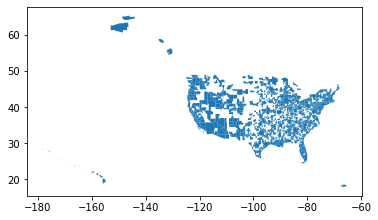

In [17]:
# Example download MSA
import geopandas as gpd
from matplotlib import pyplot as plt

url_msa = r'https://www2.census.gov/geo/tiger/TIGER2019/CBSA/tl_2019_us_cbsa.zip'
msa = gpd.read_file(url_msa)
msa.plot()
plt.show()

/opt/anaconda3/envs/2021/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www2.census.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


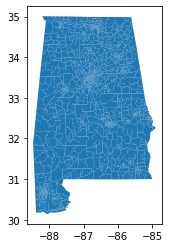

In [18]:
from bs4 import BeautifulSoup
import pandas as pd
import re
import requests
import os
import json

def get_zip(url):
    front_page = requests.get(url,verify=False)
    soup = BeautifulSoup(front_page.content,'html.parser')
    zf = soup.find_all("a",href=re.compile(r"zip"))
    # Maybe should use href 
    zl = [os.path.join(url,i['href']) for i in zf]
    return zl

base_url = r'https://www2.census.gov/geo/tiger/TIGER2021/TRACT/'
res = get_zip(base_url)

geo_tract = []
for surl in res:
    geo_tract.append(gpd.read_file(surl))

geo_full = pd.concat(geo_tract)

# See State FIPS codes
# https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696

geo_full[geo_full['STATEFP'] == '01'].plot()
plt.show()

In [19]:
def get_tract(state_code, region):
    
    test = censusdata.download('acs5', 2013, censusdata.censusgeo([('state', state_code),
        ('county', '*'), ('block group', '*')]), ['B19013_001E'])
    area_code = pd.DataFrame(test.index.astype(str))
    area_code['state'] = area_code[0].apply(lambda x:re.findall('state:(\d+)',x)[0])
    area_code['county'] = area_code[0].apply(lambda x:re.findall('county:(\d+)',x)[0])
    area_code['tract'] = area_code[0].apply(lambda x:re.findall('tract:(\d+)',x)[0])
    area_code['block'] = area_code[0].apply(lambda x:re.findall('block group:(\d+)',x)[0])
    
    area_code['tract'] = area_code['state'].astype('str')+area_code['county'].astype('str')+\
                    area_code['tract'].astype('str')
    
    code = area_code.groupby(['state', 'county', 'tract'])['block'].sum()
    code = pd.DataFrame(code)
    code.reset_index(inplace=True)
    code['region'] = region
    code = code.drop(columns=['block'])
    
    return code

In [21]:
def get_area(state_code, region, geo_i):
    tract = get_tract(state_code, region)
    area = geo_tract[geo_i].loc[:, ['GEOID', 'ALAND']]
    area = area.rename(columns = {'GEOID': 'tract'})
    Final_Area = tract.merge(area, how='left', on='tract')
    
    # Deal with missing value with mean of left area
    left_mean_area = {}
    for i in Final_Area['county'].unique():
        left_area = geo_tract[geo_i].groupby('COUNTYFP')['ALAND'].sum()[i] - \
                    Final_Area.groupby('county')['ALAND'].sum()[i]
        left_mean = left_area/len(Final_Area[(Final_Area['ALAND'].isnull() == True)&(Final_Area['county'] == i)])
        left_mean_area[i] = left_mean
    
    Final_Area['ALAND'] = Final_Area['ALAND'].fillna(Final_Area['county'].map(left_mean_area))
    
    return Final_Area

In [ ]:
FL = get_area('12', 'Florida', 9)

In [ ]:
GA = get_area('13', 'South East', 10)
NC = get_area('37', 'South East', 33)
SC = get_area('45', 'South East', 40)
AL = get_area('01', 'South East', 0)
pdList = [GA, NC, SC, AL]
SouthEast = pd.concat(pdList)

In [ ]:
GA = get_area('13', 'South', 10)
AL = get_area('01', 'South', 0)
AR = get_area('05', 'South', 3)
IN = get_area('18', 'South', 14)
KY = get_area('21', 'South', 17)
LA = get_area('22', 'South', 18)
MS = get_area('28', 'South', 24)
TN = get_area('47', 'South', 42)
pdList = [GA, AL, AR, IN, KY, LA, MS, TN]
South = pd.concat(pdList)

In [ ]:
NM = get_area('35', 'South West', 31)
OK = get_area('40', 'South West', 36)
TX = get_area('48', 'South West', 43)
pdList = [NM, OK, TX]
SouthWest = pd.concat(pdList)

In [ ]:
NM = get_area('35', 'South', 31)
AZ = get_area('04', 'South', 2)
CO = get_area('08', 'South', 5)
ID = get_area('16', 'South', 12)
MT = get_area('30', 'South', 26)
NV = get_area('32', 'South', 28)
OR = get_area('41', 'South', 37)
UT = get_area('49', 'South', 44)
WY = get_area('56', 'South', 50)
pdList = [NM, AZ, CO, ID, MT, NV, OR, UT, WY]
Western = pd.concat(pdList)

In [ ]:
CA = get_area('06', 'California', 4)

In [ ]:
FL.to_csv('FL_area.csv')
SouthEast.to_csv('SouthEast_area.csv')
South.to_csv('South_area.csv')
SouthWest.to_csv('SouthWest_area.csv')
Western.to_csv('Western_area.csv')
CA.to_csv('CA_area.csv')